In [211]:
from enum import Enum
from string import ascii_letters
from random import randint, uniform, choice, choices

import os
import json
import threading
import jsonschema
from time import perf_counter

from pprint import pprint  # Pretty Print for debugging

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
def get_ranges_int(bits: int, unsigned: bool = False) -> tuple[int, int]:
    """Return the range of values for a given bit width."""
    # Limit to 32 bits for practical purposes. In production remove this limit
    if unsigned:
        return (0, 2**bits)
    return (-(2 ** (bits - 1)), 2 ** (bits - 1) - 1)


def get_ranges_float(bits: int) -> tuple[float, float]:
    """Return the range of values for a given float bit width."""
    # For practical purposes, we're considering 32 and 64 bits and will have the same range
    if bits == 32:
        return (-3.4028235e38, 3.4028235e38)

    if bits == 64:
        return (-1.7976931348623157e308, 1.7976931348623157e308)

    raise ValueError("Unsupported float bit width.")


datatype_ranges = {
    **{
        f"Int{bits}": {"type": "integer", "range": get_ranges_int(bits, False)}
        for bits in [8, 16, 32, 64, 128]
    },
    **{
        f"UInt{bits}": {"type": "integer", "range": get_ranges_int(bits, True)}
        for bits in [8, 16, 32, 64]
    },
    **{
        f"Float{bits}": {"type": "number", "range": get_ranges_float(bits)}
        for bits in [32, 64]
    },
    "Boolean": {"type": "boolean"},
    "String": {"type": "string"},
}

pprint(datatype_ranges)

{'Boolean': {'type': 'boolean'},
 'Float32': {'range': (-3.4028235e+38, 3.4028235e+38), 'type': 'number'},
 'Float64': {'range': (-1.7976931348623157e+308, 1.7976931348623157e+308),
             'type': 'number'},
 'Int128': {'range': (-170141183460469231731687303715884105728,
                      170141183460469231731687303715884105727),
            'type': 'integer'},
 'Int16': {'range': (-32768, 32767), 'type': 'integer'},
 'Int32': {'range': (-2147483648, 2147483647), 'type': 'integer'},
 'Int64': {'range': (-9223372036854775808, 9223372036854775807),
           'type': 'integer'},
 'Int8': {'range': (-128, 127), 'type': 'integer'},
 'String': {'type': 'string'},
 'UInt16': {'range': (0, 65536), 'type': 'integer'},
 'UInt32': {'range': (0, 4294967296), 'type': 'integer'},
 'UInt64': {'range': (0, 18446744073709551616), 'type': 'integer'},
 'UInt8': {'range': (0, 256), 'type': 'integer'}}


## Generate CSV's and its jsonschema for validation

In [200]:
def random_string(length: int = 10) -> str:
    """Generate a random string of fixed length."""
    return ''.join(choice(ascii_letters) for _ in range(length))


class DataType(Enum):
    """Enum for data types."""

    # Some data types are commented out for practical purposes.
    Int8 = {"name": "Int8", "random_data": lambda: randint(*get_ranges_int(8, False))}
    Int16 = {"name": "Int16", "random_data": lambda: randint(*get_ranges_int(16, False))}
    Int32 = {"name": "Int32", "random_data": lambda: randint(*get_ranges_int(32, False))}
    # Int64 = {"name": "Int64", "random_data": lambda: randint(*get_ranges_int(64, False))}
    # Int128 = {"name": "Int128", "random_data": lambda: randint(*get_ranges_int(128, False))}
    UInt8 = {"name": "UInt8", "random_data": lambda: randint(*get_ranges_int(8, True))}
    UInt16 = {"name": "UInt16", "random_data": lambda: randint(*get_ranges_int(16, True))}
    UInt32 = {"name": "UInt32", "random_data": lambda: randint(*get_ranges_int(32, True))}
    # UInt64 = {"name": "UInt64", "random_data": lambda: randint(*get_ranges_int(64, True))}
    Float32 = {"name": "Float32", "random_data": lambda: uniform(*get_ranges_float(32))}
    # Float64 = {"name": "Float64", "random_data": lambda: uniform(*get_ranges_float(64))}
    Boolean = {"name": "Boolean", "random_data": lambda: choice([True, False])}
    String = {"name": "String", "random_data": lambda: random_string(randint(1, 20))}

In [213]:
def generate_jsonschema(df: pl.DataFrame) -> dict:
    """
    Generates a JSON schema with the specified number of rows and columns.
    Each column will have a unique name and type 'integer'.
    """
    properties = {}
    for col, dtype in df.schema.items():
        dtype_str = str(dtype)
        if dtype_str not in datatype_ranges:
            print(f"Unsupported data type: {dtype_str}")
            continue

        dtype_info = datatype_ranges[dtype_str]
        properties[col] = {"type": dtype_info["type"]}
        if "range" in dtype_info:
            properties[col]["minimum"] = dtype_info["range"][0]
            properties[col]["maximum"] = dtype_info["range"][1]

    schema = {
        "$schema": "http://json-schema.org/draft-04/schema#",
        "type": "object",
        "properties": properties,
        "required": list(properties.keys()),
        "additionalProperties": False,
    }

    return schema


def generate_csv(rows: int, columns: int, path: str = "./tmp") -> bool:
    """
    Generates a CSV file with the specified number of rows and columns.
    Each column will have a unique name and random integer values.
    """

    def generate_data(dtype: DataType, size: int) -> list:
        """Generate a list of random data based on the DataType."""
        return [dtype.value["random_data"]() for _ in range(size)]

    dtype_options = list(DataType)
    data = {
        f"col_{i}-{opt.value['name']}": pl.Series(generate_data(opt, size=rows))
        for i, opt in enumerate(choices(dtype_options, k=columns))
    }

    df = pl.DataFrame(data)

    # Save the DataFrame to a CSV file
    try:
        df.write_csv(f"{path}/data_rows-{rows}_columns-{columns}.csv")
    except Exception:
        return False

    # Save the JSON schema
    schema = generate_jsonschema(df)
    with open(f"{path}/schema_rows-{rows}_columns-{columns}.json", "w") as f:
        f.write(json.dumps(schema, indent=2))

    return True

In [214]:
# Generate csvs with fixed number of rows and varying columns
rows_fixed = 1000
path_rows = os.path.join("tmp", f"rows-{rows_fixed}")
os.makedirs(path_rows, exist_ok=True)

for i in range(100, 1001, 100):
    generate_csv(rows_fixed, i, path=path_rows)

In [215]:
# Generate csvs with fixed number of columns and varying rows
columns_fixed = 100
path_columns = os.path.join("tmp", f"columns-{columns_fixed}")
os.makedirs(path_columns, exist_ok=True)
for i in range(1000, 10001, 1000):
    generate_csv(i, columns_fixed, path=path_columns)

## Plot results

Measure time of execution

In [216]:
def validate_csv(path: str, n_workers: int = 4) -> pl.DataFrame:
    # Load the CSV file and its schema
    df = pl.read_csv(path)
    schema_path = path.replace(".csv", ".json").replace("data", "schema")
    with open(schema_path, "r") as f:
        schema = json.load(f)

    # Chunkiy
    chunk_size = len(df) // n_workers
    chunks = [df[i : i + chunk_size] for i in range(0, len(df), chunk_size)]

    # Start threads to validate each chunk
    threads = []
    for chunk in chunks:
        thread = threading.Thread(
            target=validate_chunks, args=(chunk.to_dicts(), schema)
        )
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    return df


def validate_chunks(data: list[dict], schema: dict) -> bool:
    for item in data:
        try:
            jsonschema.validate(instance=item, schema=schema)
        except Exception as e:
            print(f"Validation error: {repr(e)} - {item}")


### Fixed rows

In [ ]:
# Listing generated CSV files of fixed rows
data_time_rows = []
num_workers_rows = 1
csvs = os.listdir(path_rows)
for csv in csvs:
    if not csv.endswith(".csv"):
        continue

    print(f"Validating {csv}...", end=" ")
    file_path = os.path.join(path_rows, csv)
    start_time = perf_counter()
    df = validate_csv(file_path, num_workers_rows)
    total_time = perf_counter() - start_time
    data_time_rows.append((df.shape[1], total_time))
    print(f"Done in {total_time:.2f} seconds.")

Validating data_rows-1000_columns-500.csv... Done in 20.57 seconds.
Validating data_rows-1000_columns-800.csv... Done in 32.70 seconds.
Validating data_rows-1000_columns-400.csv... Done in 16.52 seconds.
Validating data_rows-1000_columns-1000.csv... Done in 41.10 seconds.
Validating data_rows-1000_columns-100.csv... Done in 4.55 seconds.
Validating data_rows-1000_columns-300.csv... Done in 12.45 seconds.
Validating data_rows-1000_columns-700.csv... Done in 28.39 seconds.
Validating data_rows-1000_columns-900.csv... Done in 36.58 seconds.
Validating data_rows-1000_columns-600.csv... Done in 24.94 seconds.
Validating data_rows-1000_columns-200.csv... Done in 8.33 seconds.


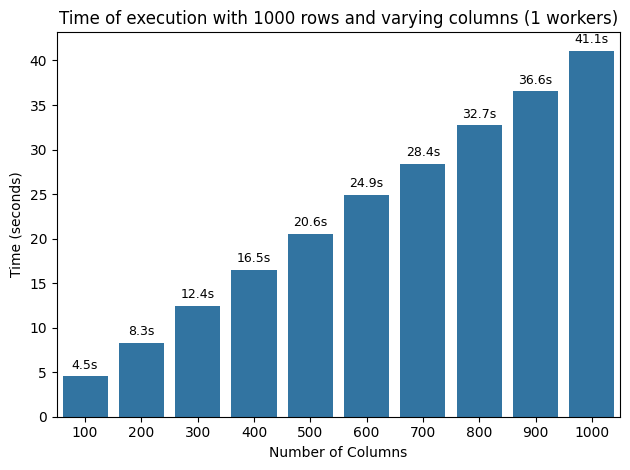

In [231]:
df = pl.DataFrame(data_time_rows, schema=["columns", "time"], orient="row")
df = df.sort("columns")

# Create the bar plot
ax = sns.barplot(data=df, x="columns", y="time")
plt.title(f"Time of execution with {rows_fixed} rows and varying columns ({num_workers_rows} workers)")
plt.xlabel("Number of Columns")
plt.ylabel("Time (seconds)")

# Add text annotations for each bar
for i, bar in enumerate(ax.patches):
    # Get the height of the bar
    height = bar.get_height()

    # Add text annotation
    ax.text(
        bar.get_x() + bar.get_width()/2,  # x position (center of bar)
        height + 0.5,                     # y position (just above bar)
        f"{height:.1f}s",                 # text (formatted time)
        ha='center',                      # horizontal alignment
        va='bottom',                      # vertical alignment
        fontsize=9,                       # font size
    )

plt.tight_layout()
plt.savefig(f"figures/rows-{rows_fixed}_num_workers-{num_workers_rows}.png")
plt.show()

### Fixed columns

In [222]:
# Listing generated CSV files of columns rows
data_time_columns = []
num_workers_columns = 1
csvs = os.listdir(path_columns)

for csv in csvs:
    if not csv.endswith(".csv"):
        continue

    print(f"Validating {csv}...", end=" ")
    file_path = os.path.join(path_columns, csv)
    start_time = perf_counter()
    df = validate_csv(file_path, num_workers_columns)
    total_time = perf_counter() - start_time
    data_time_columns.append((df.shape[0], total_time))
    print(f"Done in {total_time:.2f} seconds.")

Validating data_rows-4000_columns-100.csv... Done in 19.54 seconds.
Validating data_rows-6000_columns-100.csv... Done in 24.90 seconds.
Validating data_rows-9000_columns-100.csv... Done in 36.71 seconds.
Validating data_rows-1000_columns-100.csv... Done in 4.21 seconds.
Validating data_rows-5000_columns-100.csv... Done in 20.63 seconds.
Validating data_rows-10000_columns-100.csv... Done in 42.20 seconds.
Validating data_rows-3000_columns-100.csv... Done in 12.39 seconds.
Validating data_rows-2000_columns-100.csv... Done in 8.57 seconds.
Validating data_rows-7000_columns-100.csv... Done in 29.41 seconds.
Validating data_rows-8000_columns-100.csv... Done in 33.54 seconds.


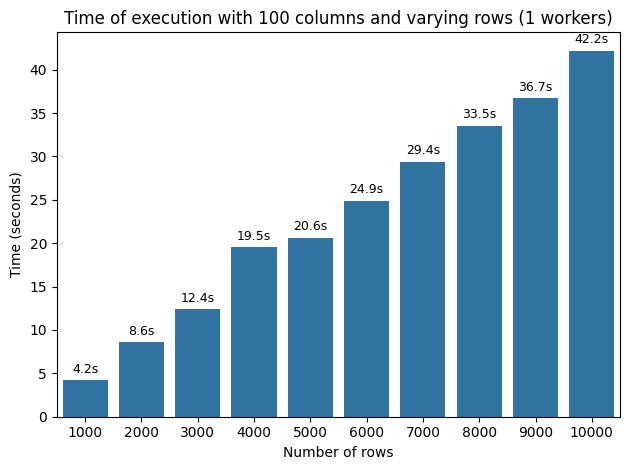

In [232]:
df = pl.DataFrame(data_time_columns, schema=["rows", "time"], orient="row")
# Sort by rows to ensure bars are in order
df = df.sort("rows")

# Create the bar plot
ax = sns.barplot(data=df, x="rows", y="time")
plt.title(f"Time of execution with {columns_fixed} columns and varying rows ({num_workers_columns} workers)")
plt.xlabel("Number of rows")
plt.ylabel("Time (seconds)")

# Add text annotations for each bar
for i, bar in enumerate(ax.patches):
    # Get the height of the bar
    height = bar.get_height()

    # Add text annotation
    ax.text(
        bar.get_x() + bar.get_width()/2,  # x position (center of bar)
        height + 0.5,                     # y position (just above bar)
        f"{height:.1f}s",                 # text (formatted time)
        ha='center',                      # horizontal alignment
        va='bottom',                      # vertical alignment
        fontsize=9,                       # font size
    )

plt.tight_layout()
plt.savefig(f"figures/columns-{columns_fixed}_num_workers-{num_workers_rows}.png")
plt.show()